In [1]:
"""
Mask R-CNN
Train on the toy Balloon dataset and implement color splash effect.
Copyright (c) 2018 Matterport, Inc.
Licensed under the MIT License (see LICENSE for details)
Written by Waleed Abdulla
------------------------------------------------------------
Usage: import the module (see Jupyter notebooks for examples), or run from
       the command line as such:
    # Train a new model starting from pre-trained COCO weights
    python3 balloon.py train --dataset=/path/to/balloon/dataset --weights=coco
    # Resume training a model that you had trained earlier
    python3 balloon.py train --dataset=/path/to/balloon/dataset --weights=last
    # Train a new model starting from ImageNet weights
    python3 balloon.py train --dataset=/path/to/balloon/dataset --weights=imagenet
    # Apply color splash to an image
    python3 balloon.py splash --weights=/path/to/weights/file.h5 --image=<URL or path to file>
    # Apply color splash to video using the last weights you trained
    python3 balloon.py splash --weights=last --video=<URL or path to file>
"""

import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import skimage
# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils

# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

/home/ye/user/yejg/SW_DATA/Or/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import skimage
dataset_dir='../../Eye/images/test/'
json_dir='../../Eye/images/'

In [3]:
class EyeConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "Eye"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 6  # Background + balloon

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

In [4]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [5]:
annotations=json.load(open('../../Eye/images/via_region_data.json'))
annotations = list(annotations.values())  # don't need the dict keys

# The VIA tool saves images in the JSON even if they don't have any
# annotations. Skip unannotated images.
annotations = [a for a in annotations if a['regions']]
print(len(annotations))
#print(annotations[0])
print(annotations[0]['regions']['0']['region_attributes']['OpticDisc'])
print(annotations[0]['regions']['1']['region_attributes']['OpticDisc'])
print(annotations[0]['regions']['3']['region_attributes']['OpticDisc'])
print(annotations[4]['regions'])
#for a in annotations:
#    polygons = [r['shape_attributes'] for r in a['regions'].values()]
#    print(polygons)

13
OpticDisc
Hemorrhages
Microaneurysms
{'0': {'shape_attributes': {'name': 'circle', 'cx': 1036, 'cy': 1244, 'r': 295}, 'region_attributes': {'OpticDisc': 'OpticDisc'}}, '1': {'shape_attributes': {'name': 'polygon', 'all_points_x': [1382, 1640, 1899, 1918, 2251, 2344, 2745, 2919, 2648, 2373, 1966, 1650, 1382], 'all_points_y': [1434, 1718, 1692, 1915, 1818, 2144, 1947, 1191, 1095, 1685, 1556, 1117, 1434]}, 'region_attributes': {'OpticDisc': 'Microaneurysms'}}, '2': {'shape_attributes': {'name': 'ellipse', 'cx': 2212, 'cy': 1418, 'rx': 304, 'ry': 229}, 'region_attributes': {'OpticDisc': 'Hemorrhages'}}, '3': {'shape_attributes': {'name': 'polygon', 'all_points_x': [965, 1033, 2092, 2622, 2457, 965], 'all_points_y': [1640, 2296, 2648, 2622, 2247, 1640]}, 'region_attributes': {'OpticDisc': 'Venules'}}, '4': {'shape_attributes': {'name': 'polygon', 'all_points_x': [1908, 2170, 2761, 3578, 3084, 2554, 1973, 1908], 'all_points_y': [262, 752, 927, 759, 226, 10, 39, 262]}, 'region_attributes':

In [6]:
class EyeDataset(utils.Dataset):

    def load_Eye(self, dataset_dir):
        """Load a subset of the Balloon dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("Eye", 1, "OpticDisc")
        self.add_class("Eye", 2, "Exudates")
        self.add_class("Eye", 3, "Venules")
        self.add_class("Eye", 4, "Hemorrhages")
        self.add_class("Eye", 5, "Microaneurysms")
        self.add_class("Eye", 6, "Arterioles")

        # Train or validation dataset?
        #assert subset in ["train", "val"]
        #dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        annotations = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r['shape_attributes'] for r in a['regions'].values()]

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]
            ann=[a['regions'][str(i)]['region_attributes']['OpticDisc'] for i in range(len(a['regions']))]
            
            self.add_image(
                "Eye",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                annotations=ann)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a balloon dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "Eye":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
        #    # Get indexes of pixels inside the polygon and set them to 1
        #    rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
        #    mask[rr, cc, i] = 1
             assert p['name'] in ['circle','ellipse','polygon','rect']
             if p['name']=='circle':
                cy,cx,radius=p['cy'],p['cx'],p['r']
                rr,cc=skimage.draw.circle(cy,cx,radius)
             if p['name']=='ellipse':
                cy,cx,ry,rx=p['cy'],p['cx'],p['ry'],p['rx']
                rr,cc=skimage.draw.ellipse(cy,cx,ry,rx)
             if p['name']=='polygon':
                cy,cx=p['all_points_y'],p['all_points_x']
                rr,cc=skimage.draw.polygon(cy,cx)
             if p['name']=='rect':
                cy,cx,width,height=p['y'],p['x'],p['width'],p['height']
                y,x=[cy-height,cy-height,cy+height,cy+height],[cx-width,cx+width,cx-width,cx+width]
                rr,cc=skimage.draw.polygon(y,x)
             mask[rr,cc,i]=i 
        
        

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "Eye":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id) 

In [7]:
dataset_Eye=EyeDataset()
dataset_Eye.load_Eye(dataset_dir)
dataset_Eye.prepare()
eyeConfig=EyeConfig()
eyeConfig.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                19
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTA

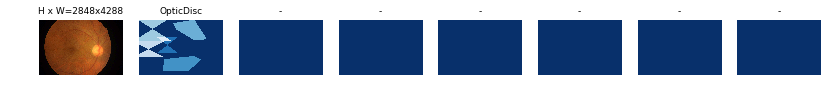

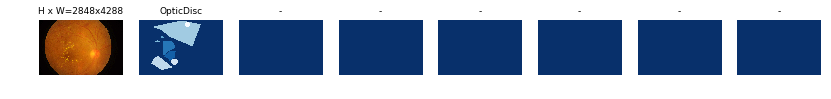

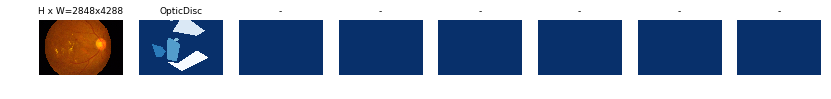

In [9]:
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 
# Load and display random samples
image_ids = np.random.choice(dataset_Eye.image_ids, 3)
for image_id in image_ids:
    image = dataset_Eye.load_image(image_id)
    mask, class_ids = dataset_Eye.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_Eye.class_names,limit=dataset_Eye.num_classes)

In [11]:
dataset_Eye.class_names

['BG',
 'OpticDisc',
 'Exudates',
 'Venules',
 'Hemorrhages',
 'Microaneurysms',
 'Arterioles']

In [10]:
print("Image Count: {}".format(len(dataset_Eye.image_ids)))
print("Class Count: {}".format(dataset_Eye.num_classes))
for i, info in enumerate(dataset_Eye.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 13
Class Count: 7
  0. BG                                                
  1. OpticDisc                                         
  2. Exudates                                          
  3. Venules                                           
  4. Hemorrhages                                       
  5. Microaneurysms                                    
  6. Arterioles                                        


##  Bounding Boxes
Rather than using bounding box coordinates provided by the source datasets, we compute the bounding boxes from masks instead. This allows us to handle bounding boxes consistently regardless of the source dataset, and it also makes it easier to resize, rotate, or crop images because we simply generate the bounding boxes from the updates masks rather than computing bounding box transformation for each type of image transformation.

image_id  10 ../../Eye/images/test/IDRiD_088.jpg
image                    shape: (2848, 4288, 3)       min:    0.00000  max:  255.00000  uint8
mask                     shape: (2848, 4288, 11)      min:    0.00000  max:    1.00000  bool
class_ids                shape: (11,)                 min:    1.00000  max:    1.00000  int32
bbox                     shape: (11, 4)               min:    0.00000  max: 3678.00000  int32


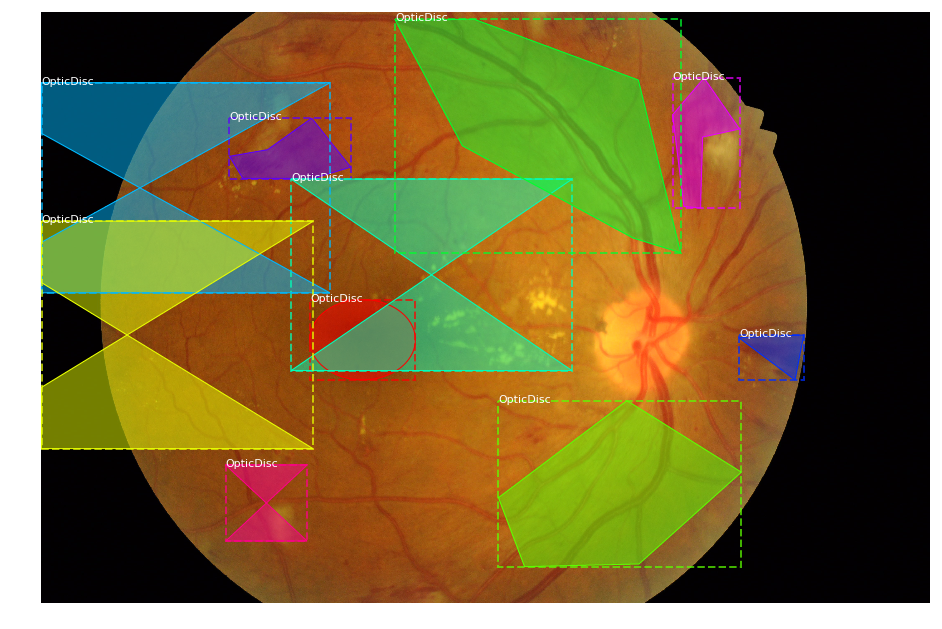

In [16]:
# Load random image and mask.# Load  
import random
image_id = random.choice(dataset_Eye.image_ids)
image = dataset_Eye.load_image(image_id)
mask, class_ids = dataset_Eye.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset_Eye.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset_Eye.class_names)

## Mini mask

image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (19,)                 min:    0.00000  max: 4288.00000  float64
class_ids                shape: (5,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (5, 4)                min:  108.00000  max:  869.00000  int32
mask                     shape: (1024, 1024, 5)       min:    0.00000  max:    1.00000  bool


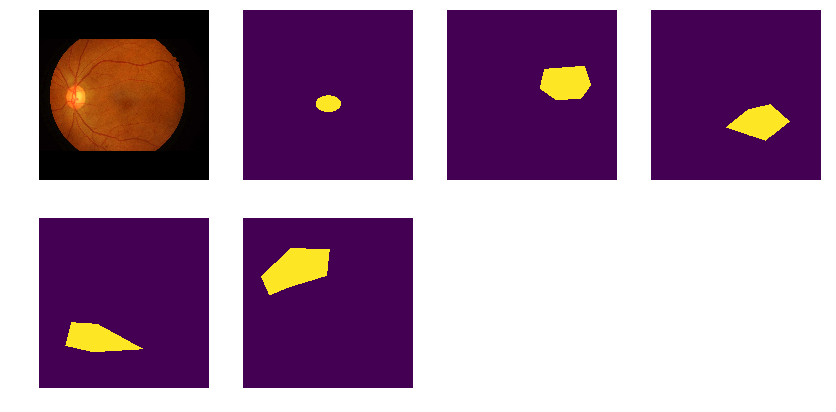

In [22]:
from mrcnn.visualize import display_images
image_id = np.random.choice(dataset_Eye.image_ids, 1)[0]
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset_Eye, eyeConfig, image_id, use_mini_mask=False)

log("image", image)
log("image_meta", image_meta)
log("class_ids", class_ids)
log("bbox", bbox)
log("mask", mask)

display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

In [8]:
def color_splash(image, mask):
    """Apply color splash effect.
    image: RGB image [height, width, 3]
    mask: instance segmentation mask [height, width, instance count]
    Returns result image.
    """
    # Make a grayscale copy of the image. The grayscale copy still
    # has 3 RGB channels, though.
    gray = skimage.color.gray2rgb(skimage.color.rgb2gray(image)) * 255
    # Copy color pixels from the original color image where mask is set
    if mask.shape[-1] > 0:
        # We're treating all instances as one, so collapse the mask into one layer
        mask = (np.sum(mask, -1, keepdims=True) >= 1)
        splash = np.where(mask, image, gray).astype(np.uint8)
    else:
        splash = gray.astype(np.uint8)
    return splash


def detect_and_color_splash(model, image_path=None, video_path=None):
    assert image_path or video_path

    # Image or video?
    if image_path:
        # Run model detection and generate the color splash effect
        print("Running on {}".format(args.image))
        # Read image
        image = skimage.io.imread(args.image)
        # Detect objects
        r = model.detect([image], verbose=1)[0]
        # Color splash
        splash = color_splash(image, r['masks'])
        # Save output
        file_name = "splash_{:%Y%m%dT%H%M%S}.png".format(datetime.datetime.now())
        skimage.io.imsave(file_name, splash)
    elif video_path:
        import cv2
        # Video capture
        vcapture = cv2.VideoCapture(video_path)
        width = int(vcapture.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(vcapture.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = vcapture.get(cv2.CAP_PROP_FPS)

        # Define codec and create video writer
        file_name = "splash_{:%Y%m%dT%H%M%S}.avi".format(datetime.datetime.now())
        vwriter = cv2.VideoWriter(file_name,
                                  cv2.VideoWriter_fourcc(*'MJPG'),
                                  fps, (width, height))

        count = 0
        success = True
        while success:
            print("frame: ", count)
            # Read next image
            success, image = vcapture.read()
            if success:
                # OpenCV returns images as BGR, convert to RGB
                image = image[..., ::-1]
                # Detect objects
                r = model.detect([image], verbose=0)[0]
                # Color splash
                splash = color_splash(image, r['masks'])
                # RGB -> BGR to save image to video
                splash = splash[..., ::-1]
                # Add image to video writer
                vwriter.write(splash)
                count += 1
        vwriter.release()
    print("Saved to ", file_name)

In [9]:
model = modellib.MaskRCNN(mode="training", config=eyeConfig,
                                  model_dir=DEFAULT_LOGS_DIR)
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
            "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"])

```
print('training...')
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_Eye, dataset_Eye, 
            learning_rate=eyeConfig.LEARNING_RATE, 
            epochs=1, 
            layers='heads')
```